1. Fourieranalyse lang andauernder Signale

c) Bestimmen Sie mithilfe Ihres Codes aus Versuch 3 das Amplitudenspektrum des ausgeschnittenen Signals und stellen Sie dieses graphisch dar.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sgl
import scipy as sp
import os
import warnings
warnings.filterwarnings('ignore')

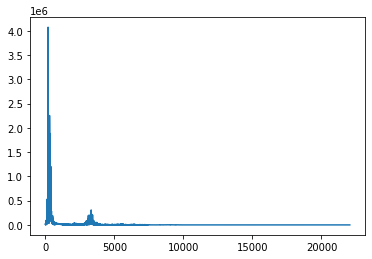

In [86]:
%matplotlib inline
sample = np.load(f"audiodateien/trigger/sebi_tief1.npy")
plt.plot(np.abs(np.fft.fft(sample))[0:len(sample)//2]);

d) Implementieren Sie die in der Vorlesung gezeigte Methode des Windowing. Zerlegen Sie
dazu das Signal in Abschnitte mit einer Länge von 512 Samples, die sich jeweils zur
Hälfte überlappen. Gewichten Sie die Samples in jedem Fenster mit einer Gaußschen
Fensterfunktion, die so gewählt wird, dass die Fensterbreite 4 Standardabweichungen
entspricht. Führen Sie in jedem Fenster eine lokale Fouriertransformation durch und
mitteln Sie dann die Fouriertransformierte über alle Fenster. Berechnen Sie daraus
wieder das Amplitudenspektrum und überprüfen Sie die Korrektheit durch Vergleich der
graphischen Darstellung mit dem Spektrum aus der vorigen Teilaufgabe.

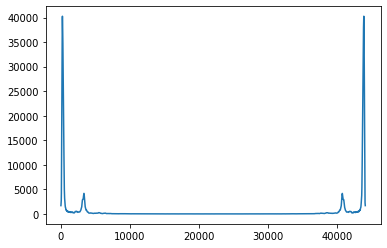

In [87]:
%matplotlib inline
def zerteilen(array):
    gauss_window = np.array(sgl.gaussian(512, 512 / 4))
    for i in range(0, len(array) - 512 + 1, 256):
        yield np.concatenate([[0] * i, list(gauss_window * array[i:i + 512]), [0] * (len(array) - (i + 512))])

def windowing_func(array):
    window = np.array(list(zerteilen(array)))
    return np.abs(np.fft.fft(window)).mean(0)

windowed_sample = windowing_func(sample)

plt.plot(windowed_sample);

2. Spracherkennung

a) Für den Spracherkenner brauchen wir zunächst die Referenzspektren für die vier Befehle
”Hoch”, ”Tief”, ”Links” und ”Rechts”. Nehmen Sie dazu jeweils 5 Beispiele pro Befehl auf
und berechnen Sie deren Spektren mit der Windowing-Methode aus Aufgabe 1. Achten
Sie darauf, das die 5 Beispiele vom selben Sprecher stammen. Das Referenzspektrum
erhalten Sie durch Mittelung über die 5 Spektren. Stellen Sie Ihre 4 Referenzspektren im
Protokoll graphisch dar.

In [88]:
windowed_tief = []
windowed_hoch = []
windowed_links = []
windowed_rechts = []
windowed_tief_s = []
windowed_hoch_s = []
windowed_links_s = []
windowed_rechts_s = []
for i in range(1,6):
    windowed_tief.append(windowing_func(np.load(f"audiodateien/trigger/max_tief{i}.npy")))
    windowed_hoch.append(windowing_func(np.load(f"audiodateien/trigger/max_hoch{i}.npy")))
    windowed_links.append(windowing_func(np.load(f"audiodateien/trigger/max_links{i}.npy")))
    windowed_rechts.append(windowing_func(np.load(f"audiodateien/trigger/max_rechts{i}.npy")))
    windowed_tief_s.append(windowing_func(np.load(f"audiodateien/trigger/sebi_tief{i}.npy")))
    windowed_hoch_s.append(windowing_func(np.load(f"audiodateien/trigger/sebi_hoch{i}.npy")))
    windowed_links_s.append(windowing_func(np.load(f"audiodateien/trigger/sebi_links{i}.npy")))
    windowed_rechts_s.append(windowing_func(np.load(f"audiodateien/trigger/sebi_rechts{i}.npy")))


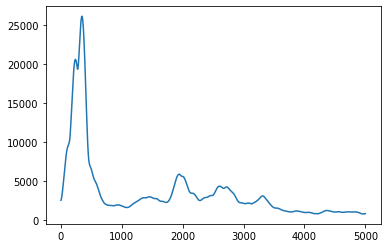

In [90]:
%matplotlib inline
plt.plot(windowed_tief[0][0:5000]);

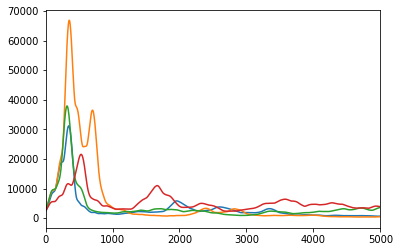

In [91]:
%matplotlib inline
mean_tief_max = np.mean(windowed_tief, axis = 0)
mean_hoch_max = np.mean(windowed_hoch, axis = 0)
mean_links_max = np.mean(windowed_links, axis = 0)
mean_rechts_max = np.mean(windowed_rechts, axis = 0)
plt.plot(mean_tief_max)
plt.plot(mean_hoch_max)
plt.plot(mean_links_max)
plt.plot(mean_rechts_max)
plt.xlim([0,5000]);


In [92]:
mean_tief_sebi = np.mean(windowed_tief_s, axis = 0)
mean_hoch_sebi = np.mean(windowed_hoch_s, axis = 0)
mean_links_sebi = np.mean(windowed_links_s, axis = 0)
mean_rechts_sebi = np.mean(windowed_rechts_s, axis = 0)

c) Schreiben Sie eine Python-Routine zur Berechnung des Korrelationskoeffizienten nach
Bravais-Pearson zum Vergleich zweier Eingabespektren. Testen Sie die Routine an ihren
Referenzspektren: beim Vergleich identischer Spektren sollte die Korrelation 1 sein, bei
verschiedenen Spektren nahe an 0.

In [93]:
test_spectrum_tief = windowing_func(np.load(f"audiodateien/trigger/max_tief6.npy"))
cov_right = sp.stats.pearsonr(test_spectrum_tief, mean_tief_max)
cov_wrong = sp.stats.pearsonr(test_spectrum_tief, mean_rechts_max)
cov_wrong1 = sp.stats.pearsonr(test_spectrum_tief, mean_links_max)
cov_wrong2 = sp.stats.pearsonr(test_spectrum_tief, mean_hoch_max)
print(f"Korrelation Tief-Tief: {cov_right[0]}")
print(f"Korrelation Tief-Rechts: {cov_wrong[0]}")
print(f"Korrelation Tief-Links: {cov_wrong1[0]}")
print(f"Korrelation Tief-Hoch: {cov_wrong2[0]}")

Korrelation Tief-Tief: 0.9962095511205851
Korrelation Tief-Rechts: 0.6043476025104905
Korrelation Tief-Links: 0.9392660463821478
Korrelation Tief-Hoch: 0.8154619086292585


d) Implementieren Sie den Spracherkenner nach der oben gezeigten Architektur und testen
Sie ihn an beiden Datensätzen. Geben Sie jeweils an, wie viel Prozent der Testdatensätze korrekt bzw. falsch erkannt wurden (d.h. die Detektions- und die Fehlerrate) und
diskutieren Sie das Ergebnis.

In [94]:
def spracherkenner(spektrum):
    referenz_spektren = [mean_hoch_max, mean_links_max, mean_rechts_max, mean_tief_max, mean_hoch_sebi, mean_links_sebi, mean_rechts_sebi, mean_tief_sebi]
    cor = 0
    idx = 0
    name = ""
    befehl = ""
    for i in range(len(referenz_spektren)):
        cov = sp.stats.pearsonr(spektrum, referenz_spektren[i])[0]
        if cov > cor:
            cor = cov
            idx = i
    if idx >= 4:
        name = "sebi"
    else:
        name = "max"
    idxm = idx % 4
    if idxm == 0:
        befehl = "hoch"
    elif idxm == 1:
        befehl = "links"
    elif idxm == 2:
        befehl = "rechts"
    else:
        befehl = "tief"
    return (name, befehl)

In [95]:
max_hoch_richtig = 0
max_tief_richtig = 0
max_links_richtig = 0
max_rechts_richtig = 0
sebi_hoch_richtig = 0
sebi_tief_richtig = 0
sebi_links_richtig = 0
sebi_rechts_richtig = 0
namen = ["sebi", "max"]
befehle = ["hoch", "tief", "links", "rechts"]

In [98]:
for n in namen:
    for b in befehle:
        for i in range (6, 11):
            result = spracherkenner(windowing_func(np.load(f"audiodateien/trigger/{n}_{b}{i}.npy")))
            if result[0] == n and result[1] == b:
                string = n + "_" + b + "_richtig"
                globals()[string] += 1

C:\Users\Max\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [97]:
print("Statistik richtig erkannter Befehle:")
insgesamt = 0
for n in namen:
    for b in befehle:
        string = n + "_" + b + "_richtig"
        print(n + "-" + b + " richtig erkannt: " + str((globals()[string] / 5) * 100) + "%")
        insgesamt += globals()[string]
        
print("Insgesamt richtig erkannt: " + str((insgesamt / 40) * 100) + "%")

Statistik richtig erkannter Befehle:
sebi-hoch richtig erkannt: 100.0%
sebi-tief richtig erkannt: 100.0%
sebi-links richtig erkannt: 60.0%
sebi-rechts richtig erkannt: 80.0%
max-hoch richtig erkannt: 100.0%
max-tief richtig erkannt: 100.0%
max-links richtig erkannt: 100.0%
max-rechts richtig erkannt: 100.0%
Insgesamt richtig erkannt: 92.5%
